In [6]:
# Notebook to generate data and append it in df
# We use the following format: 
# Edge betweenness, length, max of degree of connecting nodes, sum of degrees of connecting nodes, stress of the edge
# euclidean distance between gradient of KK before and after taking the edge out, Expansion factor, crossings minimized
# difference in average edge length, number of nodes, number of edges

# The last two are kept for normalization purposes.

import pandas as pd
import glob
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


from src.graph_dataset import GraphDataset
from src.graph_parser import parseGraphmlFile

In [19]:
def ListOfGraphs(dir_name,ext):
    list_graphs = [parseGraphmlFile(dir_name+f,weighted=False,directed=False) for f in os.listdir(dir_name) if f.endswith('.' + ext)]
    return list_graphs

In [20]:
list_graphs = ListOfGraphs('../data/random-dag/','graphml')

In [21]:
g = list_graphs[0]

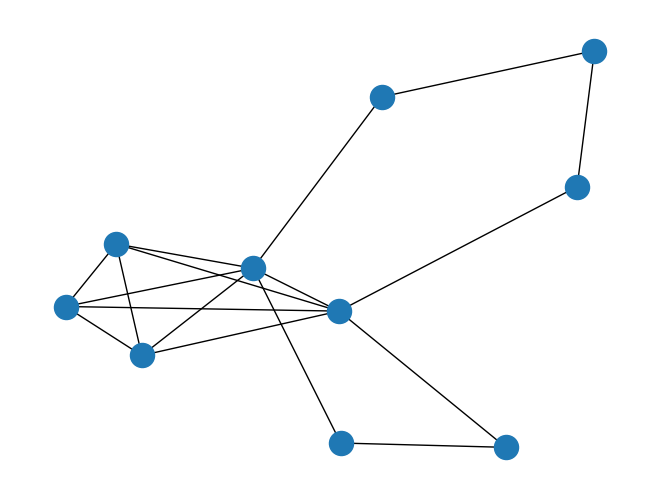

In [22]:
nx.draw(g)

In [ ]:
df = pd.read_csv('graph_train.csv')